### Imports and Setup

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import itertools
from sklearn.cluster import AgglomerativeClustering as SingleLinkage
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_t
import pandas as pd

### Dataset Creation

#### Dataset Functions

In [2]:
def TwoGuassians(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = np.random.multivariate_normal(np.zeros(dim),  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u,  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    
    return X

In [3]:
def TwoT_Student(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0, degrees=2):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = multivariate_t.rvs(np.zeros(dim), np.multiply(c,np.power(dim,power)*np.identity(dim)), df=degrees, size=NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = multivariate_t.rvs(u, np.multiply(c,np.power(dim,power)*np.identity(dim)), df=degrees, size=NumPointsInCluster)
    
    return X

In [4]:
#Takes in a d-dimensional dataset X and appends guassian noise
def PlusGuassian(X, dimension):
    #X_new = np.zeros((X.shape[0], X.shape[1]+dimension))
    #X_new[:,0:X.shape[1]-1] = np.add(X_new[:,0:X.shape[1]-1], X)# = np.copy(X)
    #print(X_new)
    #print(X_new[:,X.shape[1]:dimension+X.shape[1]].shape)
    #X_new[:,X.shape[1]:dimension+X.shape[1]] = 
    Noise = np.random.multivariate_normal(np.zeros(dimension),  np.power(dimension,-3/4)*np.identity(dimension), size = X.shape[0])
    
    return np.concatenate((X, Noise), axis=1)

In [5]:
#Double Centering Matrix
def generateH(n):
    return np.eye(n) - np.ones((n, n)) / n

#Takes in distance matrix and returns gram matrix
def gramArray(D):
    H = generateH(D.shape[0])
    return -0.5 * H @ D @ H

#Creates D^2 matrix given gram matrix X in R^(n x n) where n is number of points
def distanceSquaredArray2(XtX):
    n = XtX.shape[0]
    D_squared = np.zeros((n,n))
    for i,j in itertools.product(range(0,n),range(0,n)):
        D_squared[i][j] = XtX[i][i] - 2*XtX[i][j] + XtX[j][j]
    return D_squared

In [6]:
def makeEsimplex(X, eps):
    if eps <= 0 or eps>= 1:
        print('Failure: Epsilon not in (0,1)')
        return X
    
    D = distanceSquaredArray2(np.matmul(X, np.transpose(X)))
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    
    #Handle case where X is already an eps-simplex
    if Dmin/Dmax > (1-eps)/(1+eps):
        Xnew = np.multiply((1+eps)/Dmax, X)
        
        #Double check work
        D = distanceSquaredArray2(np.matmul(Xnew, np.transpose(Xnew)))
        Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
        Dmax = np.max(D)
        print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
        
        return Xnew
    
    #Create eps-simplex distance matrix
    A = (1/(2*eps))*((1-eps)*Dmax - (1+eps)*Dmin)
    B = (2*eps)/(Dmax-Dmin)
    
    D = B*(D + np.multiply(A,(np.ones(np.shape(D))-np.identity(D[0].shape[0]))))
    
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
    
    n = D.shape[0]
    
    #Centering matrix
    H = np.eye(n) - np.ones((n, n)) / n

    #Computing inner product matrix
    B = -0.5 * H @ D @ H

    #Eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    
    #Deal with numerical issues where the smallest eigenvalue is just barely negative
    if np.min(eigvals) < 0:
        B = B-np.min(eigvals)
    
    Xnew = np.linalg.cholesky(B)
    
    return Xnew



#Give epsilon simplex distance matrix
def makeEsimplexDistance(X, eps):
    if eps <= 0 or eps>= 1:
        print('Failure: Epsilon not in (0,1)')
        return X
    
    D = distanceSquaredArray2(np.matmul(X, np.transpose(X)))
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    
    #Handle case where X is already an eps-simplex
    if Dmin/Dmax > (1-eps)/(1+eps):
        Xnew = np.multiply((1+eps)/Dmax, X)
        
        #Double check work
        D = distanceSquaredArray2(np.matmul(Xnew, np.transpose(Xnew)))
        Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
        Dmax = np.max(D)
        print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
        
        return D
    
    #Create eps-simplex distance matrix
    A = (1/(2*eps))*((1-eps)*Dmax - (1+eps)*Dmin)
    B = (2*eps)/(Dmax-Dmin)
    
    print('A = ' + str(A) + ', B = '+ str(B))
    
    D = B*(D + np.multiply(A,(np.ones(np.shape(D))-np.identity(D[0].shape[0]))))
    
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
    
    
    return D

#Give epsilon simplex distance matrix
def makeEsimplexDistance(X, eps):
    if eps <= 0 or eps>= 1:
        print('Failure: Epsilon not in (0,1)')
        return X
    
    D = distanceSquaredArray2(np.matmul(X, np.transpose(X)))
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    
    #Handle case where X is already an eps-simplex
    if Dmin/Dmax > (1-eps)/(1+eps):
        Xnew = np.multiply((1+eps)/Dmax, X)
        
        #Double check work
        D = distanceSquaredArray2(np.matmul(Xnew, np.transpose(Xnew)))
        Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
        Dmax = np.max(D)
        print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
        
        return D
    
    #Create eps-simplex distance matrix
    A = (1/(2*eps))*((1-eps)*Dmax - (1+eps)*Dmin)
    B = (2*eps)/(Dmax-Dmin)
    
    print('A = ' + str(A) + ', B = '+ str(B))
    
    D = B*(D + np.multiply(A,(np.ones(np.shape(D))-np.identity(D[0].shape[0]))))
    
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
    
    
    return D

#### Picking Dataset


In [7]:
n=50
X = TwoGuassians(NumPointsInCluster=n ,distance=5, dim=1)
X = np.zeros((2*n,1))#np.arange(0,2.5,0.025).reshape(100,1)
X[0:n] = np.ones((n,1))
X = PlusGuassian(X,2000)
#X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=2)

12.005639457639663


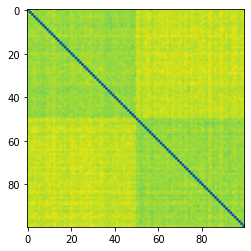

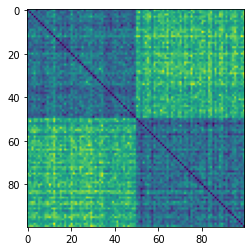

In [8]:
#Analyzing min and max distance
D = distanceSquaredArray2(np.matmul(X, np.transpose(X)))

Dmin = np.min(D+np.max(D)*np.identity(2*n))

DwoMin = D + Dmin*np.identity(2*n)  - Dmin
            
print(Dmin)
plt.imshow(D)
plt.show()
plt.imshow(DwoMin)
plt.show()

### Running T-SNE

In [9]:
#Running T-SNE
F = TSNE(learning_rate=100)
Y_features = F.fit_transform(X)
Y_xaxis = Y_features[:,0]
Y_yaxis = Y_features[:,1]

In [10]:
#Running Single Linkage on X
LinkageMethod = "ward"
clustering = SingleLinkage(n_clusters=2, linkage=LinkageMethod).fit(X)
clusteringY = SingleLinkage(n_clusters=2, linkage=LinkageMethod).fit(Y_features)

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

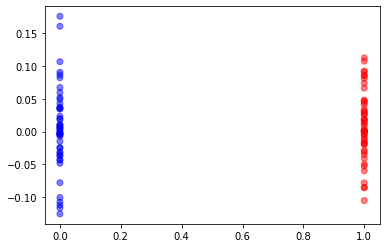

In [11]:
#Ploting first two axis of X
#plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=clustering.labels_ ,marker="o", cmap="bwr_r", alpha=0.5)
plt.grid(b=True, which='major')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("2D-Subspace Projection of X")
plt.show()

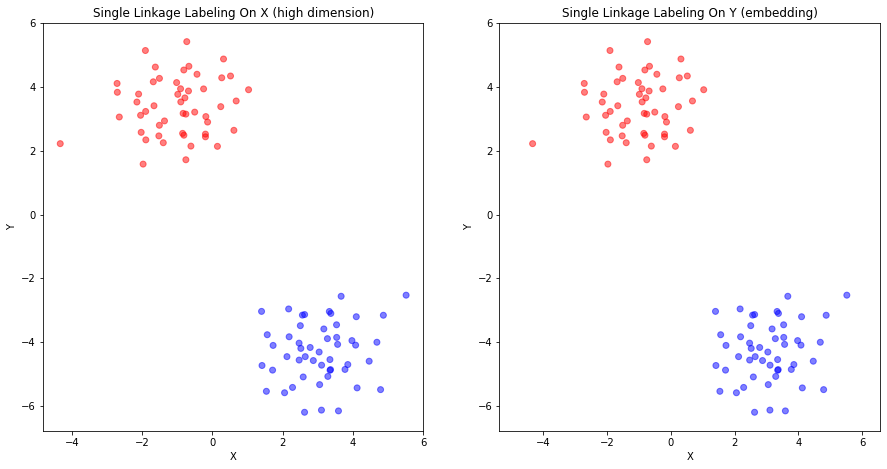

In [ ]:
#Visualizing T-SNE output
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7.5)
fig.set_figwidth(15)
ax1.scatter(Y_xaxis, Y_yaxis, c=clustering.labels_ ,marker="o", cmap="bwr_r", alpha=0.5)
ax1.set(xlabel='X', ylabel='Y', title='Single Linkage Labeling On X (high dimension)')
ax2.scatter(Y_xaxis, Y_yaxis, c=clusteringY.labels_ ,marker="o", cmap="bwr_r", alpha=0.5)
ax2.set(xlabel='X', ylabel='Y', title='Single Linkage Labeling On Y (embedding)')
plt.axis('equal')
plt.show()

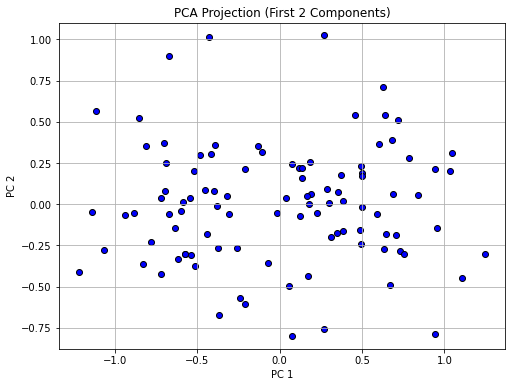

In [ ]:
from sklearn.decomposition import PCA

# Your data matrix X (n_samples x n_features)
X

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Projection (First 2 Components)')
plt.grid(True)
plt.axis('equal')
plt.show()

### Figure Making

#### Figure 1.1: Biology data 

In [ ]:
#Data from Shared and distinct transcriptomic cell types across neocortical areas by Tasic et. al.
df1 = pd.read_csv('./data/GSE115746_cells_exon_counts.csv.gz')

In [ ]:
df2 = pd.read_csv('./data/GSE115746_cells_intron_counts.csv.gz')

In [ ]:
df1.head(10)

,Unnamed: 0,F2S4_150422_002_A01,F2S4_150422_002_B01,F2S4_150422_002_C01,F2S4_150422_002_D01,F2S4_150422_002_E01,F2S4_150422_002_F01,F2S4_150422_002_G01,F2S4_150422_002_H01,F2S4_150427_001_A01,...,F1S4_180124_316_G01,F1S4_180124_316_H01,F1S4_180124_317_A01,F1S4_180124_317_B01,F1S4_180124_317_C01,F1S4_180124_317_D01,F1S4_180124_317_E01,F1S4_180124_317_F01,F1S4_180124_317_G01,F1S4_180124_317_H01
0,0610005C13Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,25,0,0,0,0,0,0
1,0610006L08Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0610007P14Rik,95,48,101,51,36,128,126,102,64,...,105,139,103,205,88,172,27,108,23,168
3,0610009B22Rik,68,47,43,42,58,14,27,68,19,...,41,86,271,118,101,174,102,121,111,119
4,0610009E02Rik,0,0,11,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,7
5,0610009L18Rik,6,7,0,0,26,8,4,0,0,...,0,0,0,12,10,16,12,0,0,5
6,0610009O20Rik,4,3,44,32,19,1,1,16,3,...,0,0,3,2,1,5,1,3,1,1
7,0610010B08Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0610010F05Rik,71,103,83,96,58,54,86,92,57,...,48,234,161,54,32,54,73,86,45,24
9,0610010K14Rik,46,68,24,61,10,35,58,10,37,...,21,68,74,38,63,89,43,64,29,20


In [ ]:
df2.head(10)

,Unnamed: 0,F2S4_150422_002_A01,F2S4_150422_002_B01,F2S4_150422_002_C01,F2S4_150422_002_D01,F2S4_150422_002_E01,F2S4_150422_002_F01,F2S4_150422_002_G01,F2S4_150422_002_H01,F2S4_150427_001_A01,...,F1S4_180124_316_G01,F1S4_180124_316_H01,F1S4_180124_317_A01,F1S4_180124_317_B01,F1S4_180124_317_C01,F1S4_180124_317_D01,F1S4_180124_317_E01,F1S4_180124_317_F01,F1S4_180124_317_G01,F1S4_180124_317_H01
0,0610005C13Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0610006L08Rik,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0610007P14Rik,3,0,48,27,0,12,0,0,8,...,0,0,0,0,10,0,0,1,0,0
3,0610009B22Rik,0,0,0,0,1,0,0,0,0,...,0,0,2,0,1,0,0,0,0,0
4,0610009E02Rik,0,0,16,0,0,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
5,0610009L18Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0610009O20Rik,5,7,0,7,18,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
7,0610010B08Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0610010F05Rik,17,0,14,21,13,17,106,33,25,...,1,4,17,2,21,7,15,9,21,6
9,0610010K14Rik,1,0,2,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [ ]:
# Import scanpy library
import scanpy as sc

# Figure settings 
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

# Load data
adata = sc.datasets.pbmc3k()

ImportError: cannot import name 'colormaps' from 'matplotlib' (/Users/szymonsnoeck/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py)

In [ ]:
# This code visualizes genes with high expression levels
sc.pl.highest_expr_genes(adata, n_top=20)

# This code calculates quality control (QC) metrics
adata_wQC = adata.copy()
sc.pp.calculate_qc_metrics(adata_wQC, percent_top=None, log1p=False, inplace=True)

# Finds mitocondrial genes
adata_wQC.var_names.str.startswith('MT-')
adata_wQC.var['mt'] = adata_wQC.var_names.str.startswith('MT-')
adata_wQC.var['mt']
for gene_name in adata_wQC.var_names[adata_wQC.var['mt']]:
    print(gene_name)

# This code calculates quality control (QC) metrics on mitochondrial genes
sc.pp.calculate_qc_metrics(adata_wQC, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

"""
The provided code uses the Scanpy library to create a violin plot 
for visualizing the distribution of three quality control metrics 
across single cells in the adata_wQC AnnData object.
"""
sc.pl.violin(adata_wQC, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)


"""
This code shows the relationship between 'total_counts' (total number of gene expression) and 
'pct_counts_mt' (percentage of mt genes in total gene expression).
Additionally, the colors of the dots are encoded according to the 'n_genes_by_counts' variable.
"""
sc.pl.scatter(adata_wQC, x='total_counts', y='pct_counts_mt', color='n_genes_by_counts')


"""
This code shows the relationship between 'total_counts' (total number of gene expressions) and 
'n_genes_by_counts' (number of genes).
Additionally, the colors of the dots are coded according to the variable 'pct_counts_mt' (percentage of mt genes in total gene expression).
"""
sc.pl.scatter(adata_wQC, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')


# Filtering cells and genes
# Filtering cells with < 200 genes and higher mt genes (>5%)
adata_wQC_filt = adata_wQC.copy()
sc.pp.filter_cells(adata_wQC_filt, min_genes=200)
adata_wQC_filt = adata_wQC_filt[adata_wQC_filt.obs.pct_counts_mt < 5, :]

# This code filters out cells containing fewer than 2500 genes.
adata_wQC_filt = adata_wQC_filt[adata_wQC_filt.obs.n_genes_by_counts < 2500, :]

# This code filters genes that are not expressed in at least 3 cells as outlier observations and deletes them from the data set.
sc.pp.filter_genes(adata_wQC_filt, min_cells=3)

# Visualizing the filtered dataset.
sc.pl.scatter(adata_wQC_filt, x='total_counts', y='pct_counts_mt', color='n_genes_by_counts')
sc.pl.scatter(adata_wQC_filt, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

# Normalization and Log transformation
norm_data = adata_wQC_filt.copy()
sc.pp.normalize_total(norm_data, target_sum=1e4)

# log n+1 transformation
sc.pp.log1p(norm_data)

# This code performs a process to identify highly variable genes (HVGs) in a single-cell RNA sequencing (scRNA-seq) dataset.
HVG_data = norm_data.copy()
sc.pp.highly_variable_genes(HVG_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
HVG_data.var['highly_variable']

# Visualizing the HVGs
sc.pl.highly_variable_genes(HVG_data)

#This code filters the gene expression matrix in the HVG data structure to include only genes with high variability.
HVG_data = HVG_data[:, HVG_data.var.highly_variable]

# Visualizing the HVGs
sc.pl.highly_variable_genes(HVG_data)

# Scaling the data
pcHVG_data = HVG_data.copy()
sc.pp.scale(pcHVG_data, max_value=10)

# Dimensionality reduction with PCA
sc.tl.pca(pcHVG_data)
sc.pl.pca_variance_ratio(pcHVG_data, log=True, n_pcs=50)
sc.pl.pca_loadings(pcHVG_data)

# Finding Neighbors by computing the neighborhood graph
sc.pp.neighbors(pcHVG_data, n_pcs=15)

# Embedding the neighborhood graph by running UMAP
umHVG_data = pcHVG_data.copy()
sc.tl.umap(umHVG_data)

# Visualization
sc.pl.umap(umHVG_data,color=['CST3', 'NKG7', 'TNFRSF4'])

#### Figure 1.2: Different Input Of Same Dimension, Same Output

In [13]:
n=100


'''
#works but t-student ASS could be higher
dimensions = [2000, 2000]
powers=[-0.75, -0.75]
C=[1.0, 1.0]
#distance=5 and degrees=5 for t-student
'''


dimensions = [2000, 2000]
powers=[-0.75, -0.75]
C=[1.0, 1.0]

Ds = dimensions.copy()
Xs = dimensions.copy()
for i in range(len(dimensions)):
    if i == 0:
        X = TwoT_Student(NumPointsInCluster=n ,distance=5, dim=dimensions[i], power=powers[i], c=C[i], degrees=5)
    if i==1:
        X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i], power=powers[i], c=C[i])
    Xs[i]=X
    Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

KeyboardInterrupt: 

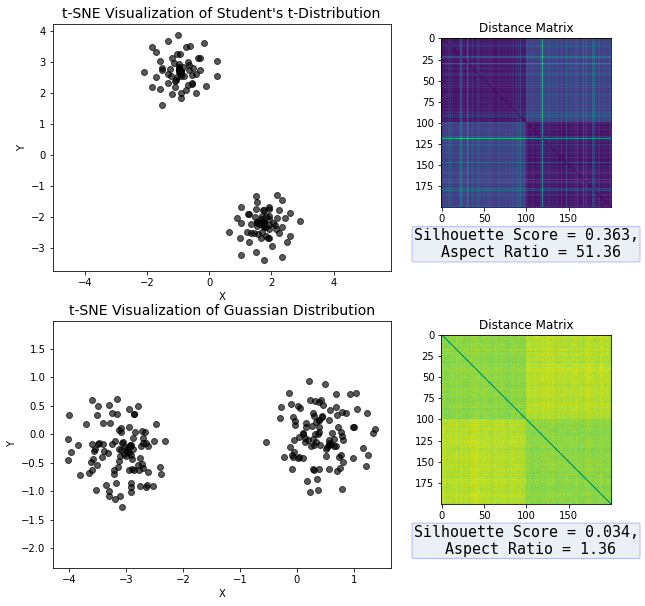

In [ ]:
#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=len(Ds), gridspec_kw={'width_ratios': [2, 1]})
fig.set_figwidth(5*len(dimensions))
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", cmap="bwr_r", alpha=0.65)
    if i==0:
        ax[i, 0].set(xlabel='X', ylabel='Y')
        ax[i, 0].set_title('t-SNE Visualization of Student\'s t-Distribution', fontsize=14, weight='light')
    if i==1:
        ax[i, 0].set(xlabel='X', ylabel='Y')
        ax[i, 0].set_title('t-SNE Visualization of Guassian Distribution', fontsize=14, weight='light')
        
    ax[i, 0].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[i, 1].imshow(Ds[i])
    ax[i, 1].set_xlabel(xlabel='Silhouette Score = ' + str(np.round(ASS,decimals=3))+',\n Aspect Ratio = '+ str(np.round(aspectRatio,decimals=2)),
                        fontsize=15, weight='light', family='monospace', bbox = {'facecolor': 'lightsteelblue', 'alpha': 0.25, 'boxstyle': "round,pad=0.1", 'ec': 'b'})
    
    #ax[i, 1].figtext(0.5, 0.01, 'Silhouette Score = ' + str(np.round(ASS,decimals=3))+',\n Aspect Ratio = '+ str(np.round(aspectRatio,decimals=2)), 
                        #fontsize=15, weight='light', family='monospace')
    
    
    pos1 = ax[i, 1].get_position()  # Get current position
    new_position = [pos1.x0, pos1.y0+0.035, pos1.width, pos1.height]  # Halve the height
    ax[i, 1].set_position(new_position)
    
    if i ==0:
        ax[i, 1].set(title='Distance Matrix') #of Student\'s t-Distribution')
    if i ==1:
        ax[i, 1].set(title='Distance Matrix') #of Guassian Distribution')

In [ ]:
name = 'Same_Output_Diff_Input_in_same_dim_9_19_25'
fig.savefig(name+'.png')
fig.savefig(name+'.jpg')

#### Different Input, Same output

In [14]:
n=100

''' This one works pretty well
dimensions = [100, 500, 1000, 3000]
powers=[-0.75, -0.75, -0.75, -0.75]
C=[0.50, 0.75, 1.0, 1.75]
'''

dimensions = [250, 500, 1000, 2000, 4000]
powers=[-0.75, -0.75, -0.75, -0.75, -0.75]
C=[0.70, 0.75, 0.90, 1.15, 1.40]

Ds = dimensions.copy()
Xs = dimensions.copy()
for i in range(len(dimensions)):
    X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i], power=powers[i], c=C[i])
    Xs[i]=X
    Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

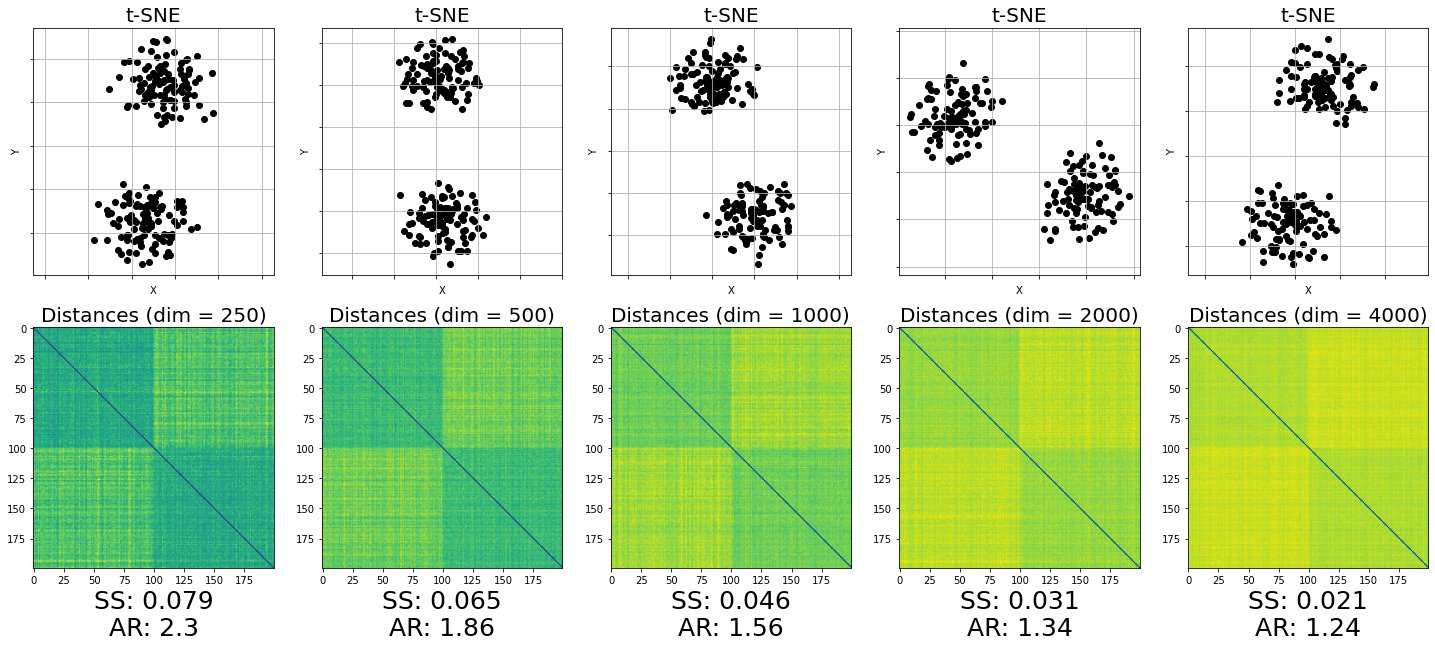

In [30]:
#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=len(Ds))
fig.set_figwidth(5*len(dimensions))
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]

    ax[0, i].grid('on')
    ax[0, i].axis('equal')
    ax[0, i].set_xticklabels([])
    ax[0, i].set_yticklabels([])
    
    ax[0, i].scatter(Y_xaxis, Y_yaxis, marker="o", color='black')#cmap="bwr_r", alpha=0.5)
    ax[0, i].set(xlabel='X', ylabel='Y')
    ax[0, i].set_title('t-SNE', fontsize=20)
    ax[0, i].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[1, i].imshow(Ds[i])
    ax[1, i].set_title('Distances (dim = '+ str(dimensions[i])+')', fontsize=20)
    
    ax[1, i].set_xlabel(  'SS: ' + str(np.round(ASS,decimals=3))+'\nAR: '+ str(np.round(aspectRatio,decimals=2) ) , fontsize=25)
    # ax[1, i].set( title='Distance Matrix (dim = '+ str(dimensions[i])+')', xlabel='Silhouette Score = ' + str(np.round(ASS,decimals=3))+'\nAspect Ratio = '+ str(np.round(aspectRatio,decimals=2)))
plt.savefig('increasing_dim_gaussians.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
name = 'Same_Output_Diff_Input_9_8_25'
fig.savefig(name+'.png')
fig.savefig(name+'.jpg')

#### Figure 2.1: Eps-close Input, Different Output

In [ ]:
n=200


dimensions = [200, 200, 200, 200]
powers=[-0.75, -0.75, -0.75, -0.75, -0.75]
C=[0.70, 0.75, 0.90, 1.15, 1.40]


Ds = dimensions.copy()
Xs = dimensions.copy()



#One Clusters
Xs[0] = np.random.multivariate_normal(np.zeros(dimensions[1]),  np.power(dimensions[1],-0.75)*np.identity(dimensions[1]), size = n)

distance = 2

#Two Clusters
Xs[1] = TwoGuassians(NumPointsInCluster=int(n/2) ,distance=distance, dim=dimensions[0])

#Four Clusters
NumPointsInCluster = int(n/4)
u = np.zeros(dimensions[2])

X = np.zeros((n, dimensions[2]))
X[0:NumPointsInCluster] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
u[0]=distance
X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
u[1]=distance
X[2*NumPointsInCluster:3*NumPointsInCluster] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
u[0]=0
X[3*NumPointsInCluster:n] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
Xs[2] = X


#A circle
pts = np.linspace(0,2*np.pi, num=n)
dataX = np.cos(pts)
dataY = np.sin(pts)

Xs[3] = np.zeros((n, dimensions[1]))
Xs[3][:,0]=dataX 
Xs[3][:,1]=dataY

A = 126.7373961238929, B = 0.007408398770926828
Dmax = 1.024 Dmin = 0.976
A = 225.5555130654426, B = 0.004236217273102865
Dmax = 1.024 Dmin = 0.9760000000000001
A = 309.5594191279244, B = 0.003103691996401979
Dmax = 1.024 Dmin = 0.9760000000000001
A = 81.32826584038473, B = 0.012000747709480274
Dmax = 1.0239999999999998 Dmin = 0.9759999999999999


/Users/szymonsnoeck/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/szymonsnoeck/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/szymonsnoeck/opt/anaconda3/lib/py

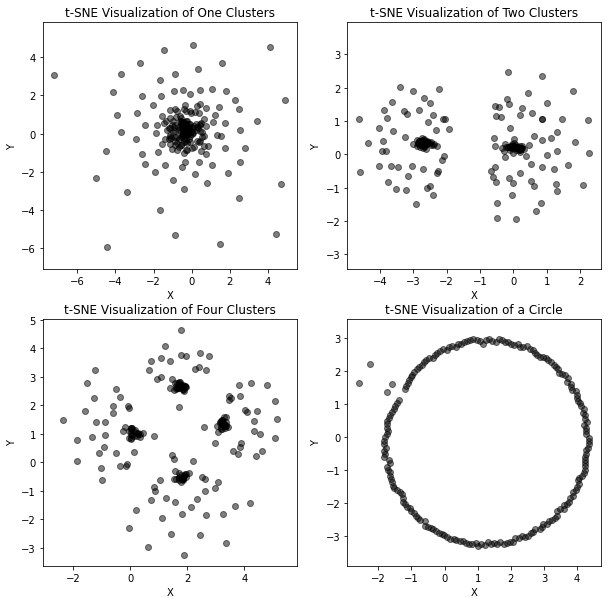

In [ ]:
### Running t-SNE w/o PCA ###

#Make the data into epsilon simplexes
eps= 0.024

Xs[0] = makeEsimplexDistance(Xs[0], eps)*1000
Xs[1] = makeEsimplexDistance(Xs[1], eps)*1000
Xs[2] = makeEsimplexDistance(Xs[2], eps)*1000
Xs[3] = makeEsimplexDistance(Xs[3], eps)*1000

#print(Xs[1])

#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)

#Setting perplexities
perps=[30, 100, 50, 20]


for i in range(2):
    for j in range(2):
        
        #Running T-SNE
        F = TSNE(learning_rate=100, perplexity=perps[i+2*j], metric='precomputed')
        
        #Plot t-SNE
        Y_features = F.fit_transform(Xs[i+2*j])
        Y_xaxis = Y_features[:,0]
        Y_yaxis = Y_features[:,1]

        ax[j, i].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", alpha=0.5)
        if i+2*j == 0:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of One Cluster')
        elif i+2*j == 1:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Two Clusters')
        elif i+2*j == 2:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Four Clusters')
        elif i+2*j == 3:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of a Circle')
            
        ax[j, i].axis('equal')

In [ ]:
fig.savefig('Same_input_diff_out_'+str(eps)+'_woPCA_9_20_25.png')
fig.savefig('Same_input_diff_out_'+str(eps)+'_woPCA_9_20_25.png')

Dmax = 1.05 Dmin = 0.95
Dmax = 1.0499999999999998 Dmin = 0.95
Dmax = 1.05 Dmin = 0.95
Dmax = 1.05 Dmin = 0.9500000000000001


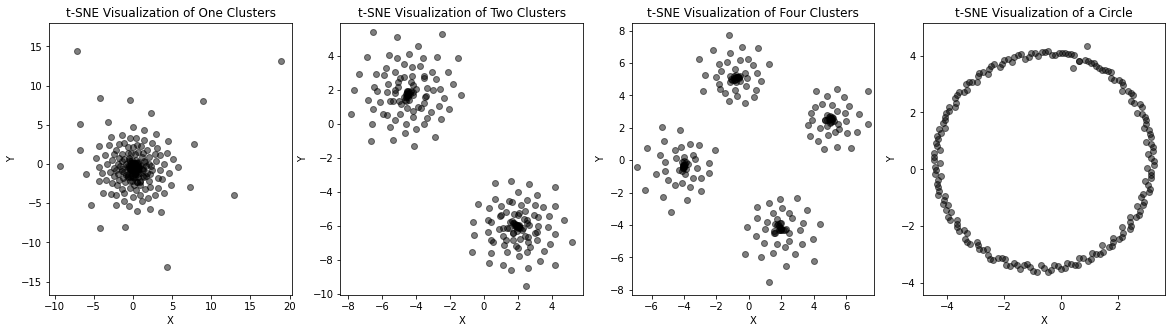

In [ ]:
### Running t-SNE with PCA except line layout ###

#Make the data into epsilon simplexes
eps= 0.05

Xs[0] = makeEsimplex(Xs[0], eps)
Xs[1] = makeEsimplex(Xs[1], eps)
Xs[2] = makeEsimplex(Xs[2], eps)
Xs[3] = makeEsimplex(Xs[3], eps)

#Creating Figure
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(5)

#Setting perplexities
perps=[30, 100, 50, 30]


for i in range(4):
        
        #Running T-SNE
        F = TSNE(learning_rate=100, perplexity=perps[i])
        
        #Plot t-SNE
        Y_features = F.fit_transform(Xs[i])
        Y_xaxis = Y_features[:,0]
        Y_yaxis = Y_features[:,1]

        ax[i].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", alpha=0.5)
        if i == 0:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of One Cluster')
        elif i == 1:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Two Clusters')
        elif i == 2:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Four Clusters')
        elif i == 3:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of a Circle')
            
        ax[i].axis('equal')

Dmax = 1.0499999999999998 Dmin = 0.95
Dmax = 1.05 Dmin = 0.95
Dmax = 1.0499999999999998 Dmin = 0.9499999999999998
Dmax = 1.05 Dmin = 0.9500000000000001


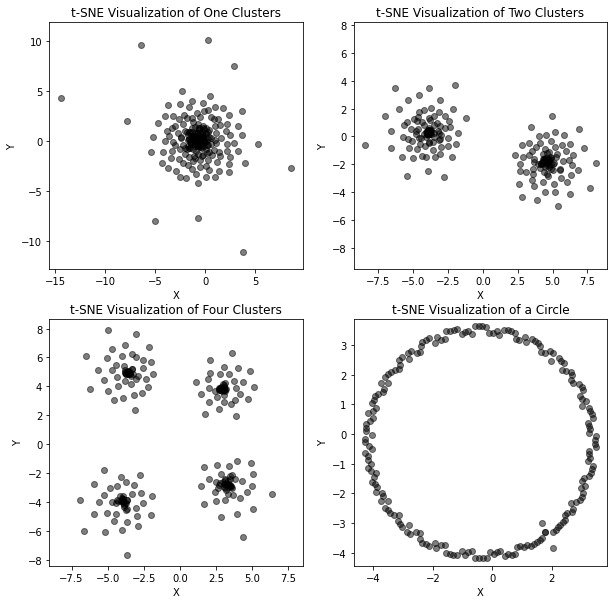

In [ ]:
### Running t-SNE with PCA except grid layout ###

#Make the data into epsilon simplexes
eps= 0.05

Xs[0] = makeEsimplex(Xs[0], eps)
Xs[1] = makeEsimplex(Xs[1], eps)
Xs[2] = makeEsimplex(Xs[2], eps)
Xs[3] = makeEsimplex(Xs[3], eps)

#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)

#Setting perplexities
perps=[30, 100, 50, 30]


for i in range(2):
    for j in range(2):
        
        #Running T-SNE
        F = TSNE(learning_rate=100, perplexity=perps[i+2*j])
        
        #Plot t-SNE
        Y_features = F.fit_transform(Xs[i+2*j])
        Y_xaxis = Y_features[:,0]
        Y_yaxis = Y_features[:,1]

        ax[j, i].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", alpha=0.5)
        if i+2*j == 0:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of One Cluster')
        elif i+2*j == 1:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Two Clusters')
        elif i+2*j == 2:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Four Clusters')
        elif i+2*j == 3:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of a Circle')
            
        ax[j, i].axis('equal')

In [ ]:
fig.savefig('Same_input_diff_out_'+str(eps)+'_wPCA_9_20_25.png')
fig.savefig('Same_input_diff_out_'+str(eps)+'_wPCA_9_20_25.jpg')

#### Figure 2.3: Moving One Point For Two Guassians

In [ ]:
n=100

dimensions = [2000, 2000]

Ds = dimensions.copy()
Xs = dimensions.copy()
for i in range(len(dimensions)):
    X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i])
    Xs[i]=X
    Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

In [ ]:
#Setting one point to the mean
i=1
Xs[i][50] = np.mean(Xs[i])
Ds[i]=distanceSquaredArray2(np.matmul(Xs[i], np.transpose(Xs[i])))

#Setting one point to the all zeros point
#i=1
#Xs[i][n] =  np.zeros(Xs[i][n].shape)
#Ds[i]=distanceSquaredArray2(np.matmul(Xs[i], np.transpose(Xs[i])))

<ipython-input-8-b7f771c8e074>:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", cmap="bwr_r", color='black', alpha=0.65)
<ipython-input-8-b7f771c8e074>:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", cmap="bwr_r", color='black', alpha=0.65)


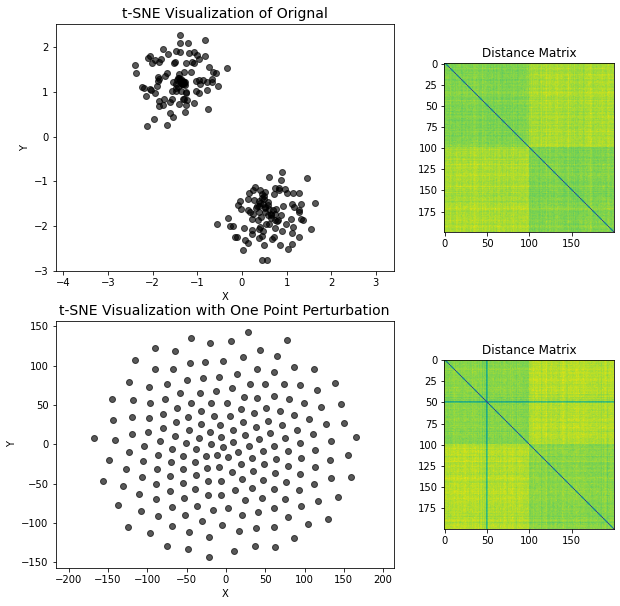

In [ ]:
#Creating nicer figure

#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=len(Ds), gridspec_kw={'width_ratios': [2, 1]})
fig.set_figwidth(5*len(dimensions))
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", cmap="bwr_r", color='black', alpha=0.65)
    if i==0:
        ax[i, 0].set(xlabel='X', ylabel='Y')
        ax[i, 0].set_title('t-SNE Visualization of Orignal', fontsize=14, weight='light')
    if i==1:
        ax[i, 0].set(xlabel='X', ylabel='Y')
        ax[i, 0].set_title('t-SNE Visualization with One Point Perturbation', fontsize=14, weight='light')
        
    ax[i, 0].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[i, 1].imshow(Ds[i])
    
    if i ==0:
        ax[i, 1].set(title='Distance Matrix') #of Student\'s t-Distribution')
    if i ==1:
        ax[i, 1].set(title='Distance Matrix') #of Guassian Distribution')

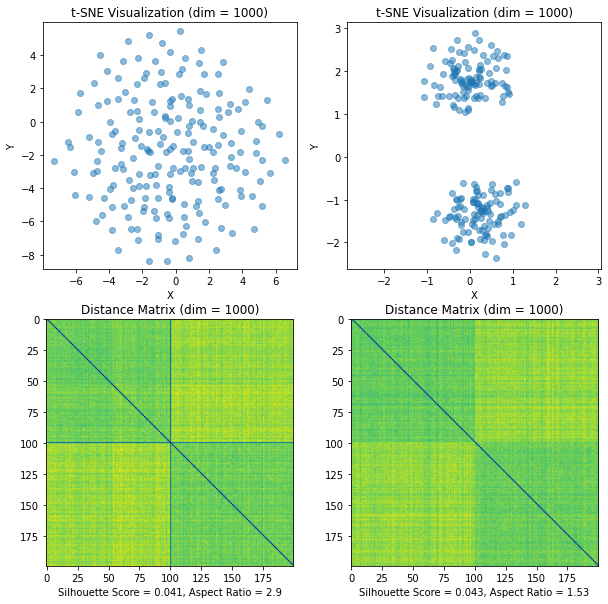

In [ ]:
#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=len(Ds))
fig.set_figwidth(5*len(dimensions))
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    ax[0, i].scatter(Y_xaxis, Y_yaxis, marker="o", cmap="bwr_r", alpha=0.5)
    ax[0, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization (dim = '+ str(dimensions[i])+')')
    ax[0, i].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[1, i].imshow(Ds[i])
    ax[1, i].set(title='Distance Matrix (dim = '+ str(dimensions[i])+')', xlabel='Silhouette Score = ' + str(np.round(ASS,decimals=3))+', Aspect Ratio = '+ str(np.round(aspectRatio,decimals=2)))

In [ ]:
#Regenerate bad rolls
i = 0 #Roll to regenerate
X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i])
Xs[i]=X
Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

In [ ]:
fig.savefig('One_Point_Perturb_9_19_25.png')

In [ ]:
fig.savefig('plot.jpg')

#### Moving One Point For MNIST

In [ ]:
df = pd.read_csv('./data/mnist_test.csv')

In [ ]:
Y = df['label']
df = df.drop('label', axis=1)

In [ ]:
Xs[0] = df.values
Ds[0]=distanceSquaredArray2(np.matmul(Xs[0], np.transpose(Xs[0])))

Xs[1] = df.values
Xs[1][4000] = np.mean(Xs[1])
Ds[1]=distanceSquaredArray2(np.matmul(Xs[1], np.transpose(Xs[1])))

In [ ]:
#Creating nicer figure

#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
fig.set_figwidth(10)
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=1000)


for i in range(2):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", cmap="bwr_r", color='black', alpha=0.65)
    ax[i, 0].set(xlabel='X', ylabel='Y')
    if i==0:
        ax[i, 0].set_title('t-SNE Visualization of Orignal', fontsize=14, weight='light')
    if i==1:
        ax[i, 0].set_title('t-SNE Visualization with One Point Perturbation', fontsize=14, weight='light')
        
    ax[i, 0].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    #ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[i, 1].imshow(Ds[i])
    
    if i ==0:
        ax[i, 1].set(title='Distance Matrix') #of Student\'s t-Distribution')
    if i ==1:
        ax[i, 1].set(title='Distance Matrix') #of Guassian Distribution')

In [ ]:
Y_yaxis.shape

(200,)

In [ ]:
Y_xaxis.shape

(200,)